# 学習データ作成 (jpeg画像から目標座標付ファイル作成)、KaitMV3用射影変換

学習に用いたjpgデータを推論の結果と合わせて表示する

In [1]:
TASK = 'mv3v1_path'      # 新たなjpegファイルを作成するTASK名

In [2]:
TASK_ORG = 'mv3v1'      # 元になるjpegファイルの存在するTASK名

In [3]:
import os
import math
import datetime
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import ipywidgets as widgets
from ipywidgets import Textarea,Layout
%matplotlib notebook
import re
import numpy as np                 # NumPy
import cv2

IMG_WIDTH = 224
IMG_HEIGHT = 224

org_path = 'data/' + TASK_ORG + "_A/apex"

fname_list = os.listdir(org_path)
#fname_list=sorted(fname_list, key=lambda fn: fn.split('_')[2])
print(fname_list)


l = Layout(flex='0 1 auto', height='100px', min_height='100px', width='auto')
process_widget = Textarea(description='ログ', value='', layout=l)
def write_log(msg):
    global process_widget
    process_widget.value = msg + "\n" + process_widget.value

['vlcsnap-2022-07-30-18h52m44s730.jpg', 'vlcsnap-2022-07-30-18h53m05s522.jpg', 'vlcsnap-2022-07-30-18h53m10s629.jpg', 'vlcsnap-2022-07-30-18h53m18s217.jpg', 'vlcsnap-2022-07-30-18h53m35s663.jpg', 'vlcsnap-2022-07-30-18h53m42s713.jpg', 'vlcsnap-2022-07-30-18h53m52s844.jpg', 'vlcsnap-2022-07-30-18h53m57s506.jpg', 'vlcsnap-2022-07-30-18h54m01s534.jpg', 'vlcsnap-2022-07-30-18h54m14s955.jpg', 'vlcsnap-2022-07-30-18h54m20s978.jpg', 'vlcsnap-2022-07-30-18h54m25s715.jpg', 'vlcsnap-2022-07-30-18h54m31s820.jpg', 'vlcsnap-2022-07-30-18h54m36s706.jpg', 'vlcsnap-2022-07-30-18h54m41s283.jpg', 'vlcsnap-2022-07-30-18h54m47s752.jpg', 'vlcsnap-2022-07-30-18h54m53s718.jpg', 'vlcsnap-2022-07-30-18h54m58s377.jpg', 'vlcsnap-2022-07-30-18h55m13s471.jpg', 'vlcsnap-2022-07-30-18h55m19s241.jpg', 'vlcsnap-2022-07-30-18h55m24s213.jpg', 'vlcsnap-2022-07-30-18h55m30s034.jpg', 'vlcsnap-2022-07-30-18h58m28s312.jpg', 'vlcsnap-2022-07-30-18h58m34s768.jpg', 'vlcsnap-2022-07-30-18h58m41s065.jpg', 'vlcsnap-2022-07-30-18h5

In [4]:
t_delta=datetime.timedelta(hours=9)
JST=datetime.timezone(t_delta,'JST')
tm=datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9))).strftime("%Y%m%d%H%M%S")

<IPython.core.display.Javascript object>


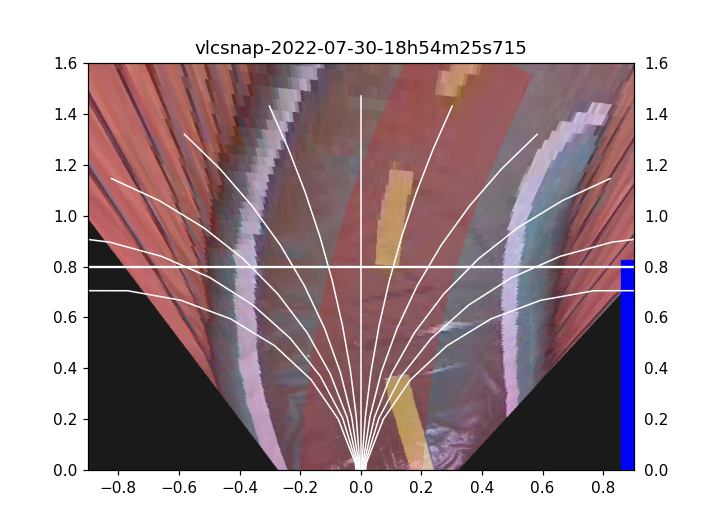

Textarea(value='', description='ログ', layout=Layout(flex='0 1 auto', height='100px', min_height='100px', width=…

In [5]:
fig = plt.figure()

def setup_ax():
    global ax, xlim, ylim
    ax= fig.add_subplot(1,1,1)
    ax.set_xlim(-0.9, 0.9)
    ax.set_ylim(0, 1.6)
    #ax.axis("off")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.tick_params(labelright=True)

setup_ax()

image = np.zeros((244, 244, 3), np.uint8)
iframe = 0

src_pt = np.float32([[ 58, 47], [ 14,98], [188,93], [141, 44]])
dst_pt = np.float32([[ 45, 30], [ 45,120], [135,120], [135, 30]])*4


dst_img_size=(720,640)
M = cv2.getPerspectiveTransform(src_pt, dst_pt)

def plot_trj(v,w,c,line_w,al):
    dt = 0.1
    t, x, y = 0, 0, 0
    x0 = -0.15 # 車両先端から回転中心までの距離
    xx  =[]
    yy = []
    for i in range(10):  # 2sec
        if w == 0:
            xx.append(v*t + x0)
            yy.append(0)
        else:
            xx.append(v*math.sin(w*t)/w + x0)
            yy.append(v*(1-math.cos(w*t))/w)
        t = t + dt
    ax.plot(yy,xx,color=c,lw=line_w,alpha=al)

def plot_trj_jetracer(s,c,line_w,al):
    plot_trj(1.8, (1.8/0.43)*s,c,line_w,al)

def show_trj_img(img):
    for s in np.arange(-0.5,0.51,0.1):
        plot_trj_jetracer(s,'w',1,1.0)
    ax.plot([-0.9,0.9],[0.8,0.8],color='w')
    ax.imshow(img, extent=[*xlim, *ylim], aspect='auto', alpha=0.9)
    plt.show()
    
def show_trj_path_img(s,acc,image,title):
    image_trans = cv2.warpPerspective(image, M, dst_img_size, flags=cv2.INTER_NEAREST)   
    image_trans = cv2.cvtColor(image_trans, cv2.COLOR_BGR2RGB)
    
    plt.clf()
    setup_ax()
    plot_trj_jetracer(s,'r',80,0.2)
    
    ax.plot([0.88,0.88],[0.0,0.8+acc],color='b',lw=10,alpha=1.0)
    plt.title(title)
    show_trj_img(image_trans)  

import re
def parse_x_y_fname(fname):
    items = re.split('[_.]',fname)
    try:
        int(items[0])
    except ValueError:
        x, y = 112, 112
        z = items[0]
    else:
        try:
            int(items[1])
        except ValueError:
            x, y = 112, 112
            z = items[0]
        else:
            x = int(items[0])
            y = int(items[1])
            z = items[2]
    #print(x,y,z)
    return([x,y,z])
    
def skip_frame_and_show(nframe):
    global image,steer,acc,image_id
    plt.clf()
    if len(fname_list) < nframe:
        write_log('end of files')
        return
    for i in range(nframe):
        fn = fname_list.pop(0)
        img_tmp = cv2.imread('data/' + TASK_ORG + "_A/apex/"+fn)
        [x,y,image_id] = parse_x_y_fname(fn)
        #steer,acc = 0, 0
        steer = (x-112)/112
        acc = (-y+112)/112
        if img_tmp is None:
            write_log('cannot read jpg file %s' % fn)
            return
    image = cv2.resize(img_tmp, dsize=(224,224))
    show_trj_path_img(steer,acc,image,image_id)



skip_frame_and_show(1)
    
button01 = widgets.Button(description='+1')
def on_click_01(clicked_button: widgets.Button) -> None:
         skip_frame_and_show(1)
button01.on_click(on_click_01)

button10 = widgets.Button(description='+10')
def on_click_10(clicked_button: widgets.Button) -> None:
         skip_frame_and_show(10)
button10.on_click(on_click_10)

button30 = widgets.Button(description='+30')
def on_click_30(clicked_button: widgets.Button) -> None:
         skip_frame_and_show(30)
button30.on_click(on_click_30)

button_r = widgets.Button(description='<-')
def on_click_r(clicked_button: widgets.Button) -> None:
    global steer
    steer = max(-1.0,steer-0.05)
    show_trj_path_img(steer,acc,image,image_id)
button_r.on_click(on_click_r)

button_l = widgets.Button(description='->')
def on_click_l(clicked_button: widgets.Button) -> None:
    global steer
    steer = min(1.0,steer+0.05)
    show_trj_path_img(steer,acc,image,image_id)
button_l.on_click(on_click_l)


button_up = widgets.Button(description='++')
def on_click_up(clicked_button: widgets.Button) -> None:
    global acc
    acc = min(0.4,acc+0.1)
    show_trj_path_img(steer,acc,image,image_id)
button_up.on_click(on_click_up)

button_dn = widgets.Button(description='--')
def on_click_dn(clicked_button: widgets.Button) -> None:
    global acc
    acc = max(-0.4,acc-0.1)
    show_trj_path_img(steer,acc,image,image_id)
button_dn.on_click(on_click_dn)


txt = Textarea(
    value='',
    placeholder='data',
    description='event:',
    disabled=False,
    layout=Layout(width='50%', height='40px'))

category_path = 'data/'+TASK+'_A/apex/'
if not os.path.exists(category_path):
    os.makedirs(category_path)

button_file = widgets.Button(description='file')
def on_click_file(clicked_button: widgets.Button) -> None:
    xp = 112 + 112*steer
    yp = 112 - 112*acc
    tm=datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9))).strftime("%Y%m%d%H%M%S")
    filename = '%03d_%03d_%s.jpg' % (xp, yp, image_id) 
    image_path = category_path + filename
    cv2.imwrite(image_path, image)
    write_log('saved to %s' % (image_path))
    skip_frame_and_show(1)
button_file.on_click(on_click_file)
    
       
control_collection_widget = widgets.HBox([button01,button10, button30])
display(control_collection_widget)

path_collection_widget = widgets.HBox([button_file,button_dn,button_up,button_r,button_l])
display(path_collection_widget)

display(process_widget)

#ka = fig.canvas.mpl_connect('button_press_event', onclick_img)